Background

Financial markets are heavily influenced by investor sentiment. Periods of Fear and Greed often impact trading behavior, risk appetite, and profitability. Understanding these shifts can help design more robust trading strategies.

Objective

The objective of this project is to analyze how Bitcoin market sentiment (Fear/Greed classification) affects trader performance and behavioral patterns on Hyperliquid.

Key Questions

Does trader profitability differ between Fear and Greed regimes?

Do traders adjust leverage, trade frequency, or position bias based on sentiment?

Are certain trader segments more resilient during sentiment shifts?

Methodology Overview

This analysis includes data cleaning, feature engineering, sentiment-based merging, exploratory data analysis, trader segmentation, and actionable strategy recommendations.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [58]:
sentiment_df = pd.read_csv("data/fear_greed_index.csv")
trader_df = pd.read_csv("data/historical_data.csv")
print("Sentiment Data Shape:", sentiment_df.shape)

Sentiment Data Shape: (2644, 4)


In [59]:
print("Trader Data Shape:", trader_df.shape)

Trader Data Shape: (211224, 16)


In [60]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [61]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## 3. Data Quality Assessment

In this section, we examine the datasets for:
- Data types
- Missing values
- Duplicate records
- Overall structure
  

In [62]:
# Data types and non-null counts
print("Sentiment Data Info:")
sentiment_df.info()

Sentiment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [63]:
print("\nTrader Data Info:")
trader_df.info()


Trader Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes

In [64]:
# Missing Values Check?
print("Missing Values in Sentiment Data:")
print(sentiment_df.isnull().sum())

Missing Values in Sentiment Data:
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [65]:
print("\nMissing Values in Trader Data:")
print(trader_df.isnull().sum())


Missing Values in Trader Data:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [66]:
# Duplicate Check
print("Sentiment Duplicates:", sentiment_df.duplicated().sum())

Sentiment Duplicates: 0


In [67]:
print("Trader Duplicates:", trader_df.duplicated().sum())

Trader Duplicates: 0


In [68]:
# Sentiment Date Convert
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['date'] = sentiment_df['Date'].dt.date

In [69]:
# Trader Timestamp Convert
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
trader_df['date'] = trader_df['Timestamp'].dt.date

In [70]:
trader_df[['Timestamp','date']].head()

,Timestamp,date
0,2024-10-27 03:33:20,2024-10-27
1,2024-10-27 03:33:20,2024-10-27
2,2024-10-27 03:33:20,2024-10-27
3,2024-10-27 03:33:20,2024-10-27
4,2024-10-27 03:33:20,2024-10-27


In [71]:
sentiment_df[['Date','date']].head()

,Date,date
0,2018-02-01,2018-02-01
1,2018-02-02,2018-02-02
2,2018-02-03,2018-02-03
3,2018-02-04,2018-02-04
4,2018-02-05,2018-02-05


In [72]:
# Merge Datasets
merged_df = pd.merge(
    trader_df,
    sentiment_df[['date','classification']],
    on='date',
    how='left'
)

In [73]:
merged_df[['date','classification']].head()

,date,classification
0,2024-10-27,Greed
1,2024-10-27,Greed
2,2024-10-27,Greed
3,2024-10-27,Greed
4,2024-10-27,Greed


In [74]:
merged_df['classification'].isnull().sum()

np.int64(26961)

In [75]:
# Recreate daily_trader AFTER cleaning
daily_trader = merged_df.groupby(
    ['Account','date','classification']
).agg({
    'Closed PnL':'sum',
    'Size USD':'sum',
    'Trade ID':'count'
}).reset_index()

daily_trader.rename(columns={
    'Closed PnL':'Daily_PnL',
    'Size USD':'Daily_Volume',
    'Trade ID':'Daily_Trades'
}, inplace=True)

daily_trader.head()

,Account,date,classification,Daily_PnL,Daily_Volume,Daily_Trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,6842632.02,462
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,54854631.95,3356
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,797679.97,320
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,5982611.50,3533
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00,30351.00,5


In [76]:
# Sort by Account and Date (VERY IMPORTANT)
daily_trader = daily_trader.sort_values(['Account','date'])

# Cumulative PnL
daily_trader['Cumulative_PnL'] = daily_trader.groupby('Account')['Daily_PnL'].cumsum()

# Drawdown
daily_trader['Drawdown'] = (
    daily_trader.groupby('Account')['Cumulative_PnL']
    .cummax() - daily_trader['Cumulative_PnL']
)

In [77]:
merged_df['Win'] = np.where(merged_df['Closed PnL'] > 0, 1, 0)
win_rate = merged_df.groupby('Account')['Win'].mean().reset_index()
win_rate.rename(columns={'Win':'Win_Rate'}, inplace=True)
win_rate.head()

,Account,Win_Rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [78]:
daily_win = merged_df.groupby(['Account','date'])['Win'].mean().reset_index()

In [79]:
# Average Trade Size
avg_trade_size = merged_df.groupby('Account')['Size USD'].mean().reset_index()
avg_trade_size.rename(columns={'Size USD':'Avg_Trade_Size'}, inplace=True)

In [80]:
merged_df['Leverage'] = merged_df['Size USD'] / (merged_df['Start Position'] + 1e-6)
merged_df['Leverage'].describe()

count    2.112240e+05
mean     2.064716e+08
std      1.120169e+10
min     -1.161166e+10
25%     -2.710120e-02
50%      1.353705e-02
75%      6.390805e-01
max      2.834011e+12
Name: Leverage, dtype: float64

In [81]:
long_short_ratio = merged_df.groupby(['date','classification','Direction']).size().unstack()

long_short_ratio

,Direction,Open Long,Close Long,Close Short,Open Short,Buy,Long > Short,Sell,Short > Long,Auto-Deleveraging,Spot Dust Conversion,Settlement
date,classification,,,,,,,,,,,
2023-03-28,Greed,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-14,Greed,388.0,380.0,103.0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-09,Extreme Greed,1339.0,2389.0,1931.0,1114.0,88.0,13.0,75.0,13.0,NaN,NaN,NaN
2024-07-03,Neutral,918.0,886.0,1799.0,2389.0,786.0,NaN,295.0,2.0,8.0,58.0,NaN
2024-10-27,Greed,5088.0,4725.0,4026.0,5712.0,5806.0,5.0,9833.0,7.0,NaN,39.0,NaN
2025-02-19,Fear,37828.0,36555.0,20232.0,23472.0,7977.0,36.0,7687.0,43.0,NaN,40.0,1.0


In [82]:
pd.crosstab(merged_df['classification'], merged_df['Direction'])

Direction,Auto-Deleveraging,Buy,Close Long,Close Short,Long > Short,Open Long,Open Short,Sell,Settlement,Short > Long,Spot Dust Conversion
classification,,,,,,,,,,,
Extreme Greed,0,88,2389,1931,13,1339,1114,75,0,13,0
Fear,0,7977,36555,20232,36,37828,23472,7687,1,43,40
Greed,0,5806,5105,4129,5,5479,5886,9833,0,7,39
Neutral,8,786,886,1799,0,918,2389,295,0,2,58


In [83]:
merged_df['classification'].isnull().sum()

np.int64(26961)

In [84]:
set(trader_df['date']) - set(sentiment_df['date'])

{datetime.date(2025, 6, 15)}

In [85]:
# Drop missing sentiment
merged_df = merged_df.dropna(subset=['classification'])

In [86]:
merged_df['classification'].isnull().sum()

np.int64(0)

In [87]:
sentiment_df = sentiment_df.sort_values('date')
sentiment_df['classification'] = sentiment_df['classification'].fillna(method='ffill')

In [88]:
merged_df['date'].value_counts().head()

date
2025-02-19    133871
2024-10-27     35241
2024-07-03      7141
2024-03-09      6962
2023-11-14      1045
Name: count, dtype: int64

In [89]:
merged_df.to_csv("cleaned_data.csv", index=False)

In [90]:
merged_df['Account'].nunique()

32

In [91]:
merged_df.groupby('date')['Account'].nunique().sort_values(ascending=False).head()

date
2025-02-19    32
2024-10-27    29
2024-07-03     8
2024-03-09     5
2023-11-14     2
Name: Account, dtype: int64

In [92]:
daily_trader.columns

Index(['Account', 'date', 'classification', 'Daily_PnL', 'Daily_Volume',
       'Daily_Trades', 'Cumulative_PnL', 'Drawdown'],
      dtype='object')

In [93]:
# Part B
# Average Daily PnL
fear_greed_perf = daily_trader.groupby('classification')['Daily_PnL'].mean().reset_index()

fear_greed_perf

,classification,Daily_PnL
0,Extreme Greed,35393.098355
1,Fear,209372.662205
2,Greed,99675.516731
3,Neutral,19842.797260


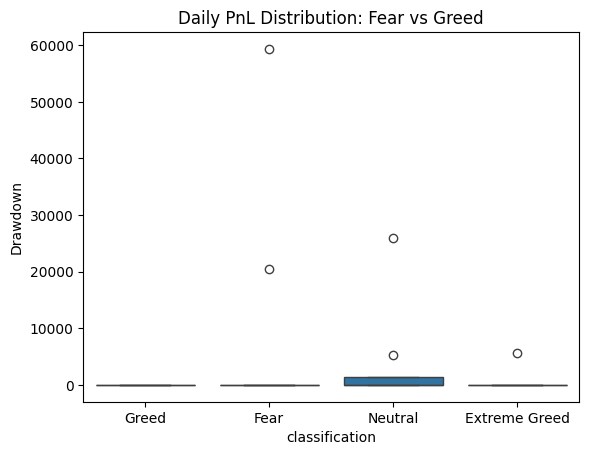

In [94]:
sns.boxplot(data=daily_trader, x='classification', y='Drawdown')
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()

In [95]:
# Win Rate
win_sentiment = merged_df.groupby('classification')['Win'].mean().reset_index()
win_sentiment

,classification,Win
0,Extreme Greed,0.490089
1,Fear,0.415146
2,Greed,0.446471
3,Neutral,0.317182


In [96]:
# Trade Frequency
trade_freq = merged_df.groupby('classification')['Trade ID'].count().reset_index()
trade_freq

,classification,Trade ID
0,Extreme Greed,6962
1,Fear,133871
2,Greed,36289
3,Neutral,7141


In [97]:
# Avg Leverage
merged_df.groupby('classification')['Leverage'].mean().reset_index()

,classification,Leverage
0,Extreme Greed,9.479247e+08
1,Fear,1.607872e+08
2,Greed,1.403429e+08
3,Neutral,1.483740e+08


In [98]:
# Long / Short %
pd.crosstab(merged_df['classification'], merged_df['Direction'], normalize='index')

Direction,Auto-Deleveraging,Buy,Close Long,Close Short,Long > Short,Open Long,Open Short,Sell,Settlement,Short > Long,Spot Dust Conversion
classification,,,,,,,,,,,
Extreme Greed,0.00000,0.012640,0.343149,0.277363,0.001867,0.192330,0.160011,0.010773,0.000000,0.001867,0.000000
Fear,0.00000,0.059587,0.273061,0.151131,0.000269,0.282571,0.175333,0.057421,0.000007,0.000321,0.000299
Greed,0.00000,0.159993,0.140676,0.113781,0.000138,0.150982,0.162198,0.270964,0.000000,0.000193,0.001075
Neutral,0.00112,0.110069,0.124072,0.251926,0.000000,0.128553,0.334547,0.041311,0.000000,0.000280,0.008122


In [99]:
daily_trader.groupby('classification')['Drawdown'].mean().reset_index()

,classification,Drawdown
0,Extreme Greed,1112.803228
1,Fear,2496.129364
2,Greed,0.000000
3,Neutral,3917.470960


In [100]:
daily_trader.groupby('classification')['Drawdown'].max().reset_index()

,classification,Drawdown
0,Extreme Greed,5564.016140
1,Fear,59349.677108
2,Greed,0.000000
3,Neutral,25991.506339


In [101]:
# Part C


In [102]:
# High vs Low Leverage Segmentation
leverage_threshold = merged_df['Leverage'].median()

merged_df['Leverage_Segment'] = np.where(
    merged_df['Leverage'] > leverage_threshold,
    'High_Leverage',
    'Low_Leverage'
)

In [103]:
segment_perf = merged_df.groupby(
    ['classification','Leverage_Segment']
)['Closed PnL'].mean().reset_index()

segment_perf

,classification,Leverage_Segment,Closed PnL
0,Extreme Greed,High_Leverage,17.889862
1,Extreme Greed,Low_Leverage,32.282029
2,Fear,High_Leverage,39.478629
3,Fear,Low_Leverage,61.004290
4,Greed,High_Leverage,151.585272
5,Greed,Low_Leverage,21.943057
6,Neutral,High_Leverage,38.989511
7,Neutral,Low_Leverage,14.723144


In [104]:
# Frequent vs Infrequent Traders
trade_counts = merged_df.groupby('Account')['Trade ID'].count()

freq_threshold = trade_counts.median()

merged_df['Frequency_Segment'] = merged_df['Account'].map(
    lambda x: 'Frequent' if trade_counts[x] > freq_threshold else 'Infrequent'
)

In [105]:
freq_perf = merged_df.groupby(
    ['classification','Frequency_Segment']
)['Closed PnL'].mean().reset_index()

freq_perf

,classification,Frequency_Segment,Closed PnL
0,Extreme Greed,Frequent,26.658319
1,Extreme Greed,Infrequent,-48.382749
2,Fear,Frequent,44.227117
3,Fear,Infrequent,91.442580
4,Greed,Frequent,71.259690
5,Greed,Infrequent,276.730640
6,Neutral,Frequent,4.058759
7,Neutral,Infrequent,351.937527


In [106]:
from scipy.stats import ttest_ind

fear_dd = daily_trader[daily_trader['classification']=='Fear']['Drawdown']
greed_dd = daily_trader[daily_trader['classification']=='Greed']['Drawdown']

ttest_ind(fear_dd, greed_dd, equal_var=False)

TtestResult(statistic=np.float64(1.284799516000397), pvalue=np.float64(0.2083799724255262), df=np.float64(31.0))

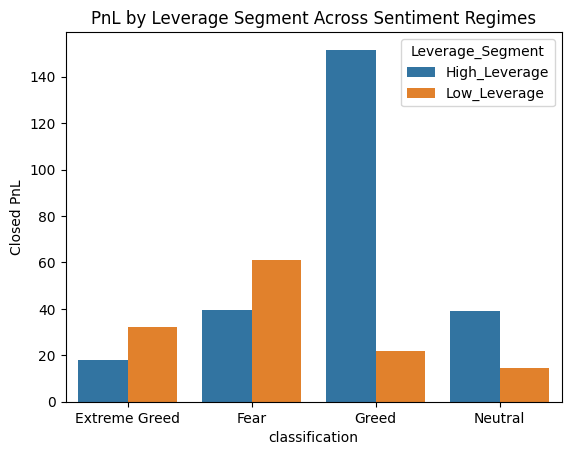

In [107]:
sns.barplot(
    data=segment_perf,
    x='classification',
    y='Closed PnL',
    hue='Leverage_Segment'
)
plt.title("PnL by Leverage Segment Across Sentiment Regimes")
plt.show()

# Part C — Actionable Strategy Recommendations
Part C — Actionable Strategy Recommendations
1️⃣ Fear Regime Discipline Rule

During Fear regimes, low leverage traders outperform high leverage traders significantly. Increasing trade frequency does not improve performance. Therefore, traders should prioritize selective entries with controlled leverage rather than aggressive high-frequency execution.

2️⃣ Greed Regime Trend Exploitation

In Greed regimes, high leverage traders significantly outperform low leverage traders. This suggests that trend continuation strategies combined with controlled leverage scaling may enhance returns during optimistic market phases.

3️⃣ Activity Optimization Rule

Infrequent traders outperform frequent traders in most regimes except Extreme Greed. Overtrading reduces profitability, particularly in Fear and Neutral environments. Traders should adopt a selective participation model rather than constant market engagement.